In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import display

from disruption_survival_analysis.sweep_config import create_experiment_groups, get_experiments


from disruption_survival_analysis.plot_experiments import plot_auroc_timeslice_all_vs_horizon, plot_fpr_vs_threshold, plot_threshold_vs_fpr, plot_auroc_timeslice_shot_avg_vs_horizon, plot_warning_time_vs_false_alarm_rate, plot_roc_curve, plot_warning_time_vs_threshold
from disruption_survival_analysis.plot_experiments import plot_risk_compare_models, plot_ettd_compare_models
from disruption_survival_analysis.plot_experiments import plot_disruptive_vs_non_disruptive_shot_durations

device = 'synthetic'
dataset_path = 'test'
#device = 'cmod'
#dataset_path = 'preliminary_dataset_no_ufo'

# models, alarms, metrics, and minimum warning times to use
models = ['rf', 'dsm']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.02]

# Load models and create experiments
experiment_groups = create_experiment_groups(device, dataset_path, models, alarms, metrics, min_warning_times)

c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/rf_sthr_auroc_20ms.yaml
---
Loaded model from models/synthetic/test/rf_sthr_auroc_20ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/dsm_sthr_auroc_20ms.yaml
---
Loaded model from models/synthetic/test/dsm_sthr_auroc_20ms.pkl


## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

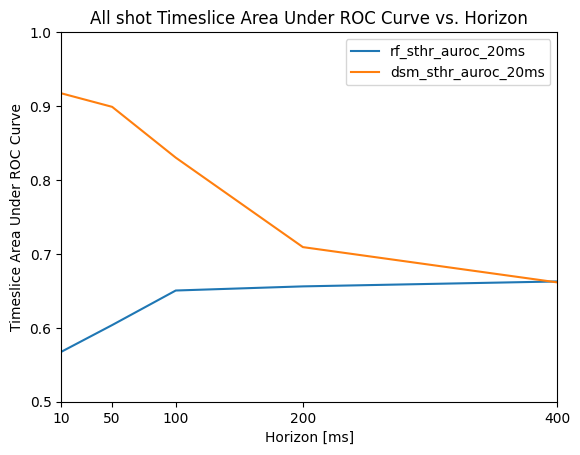

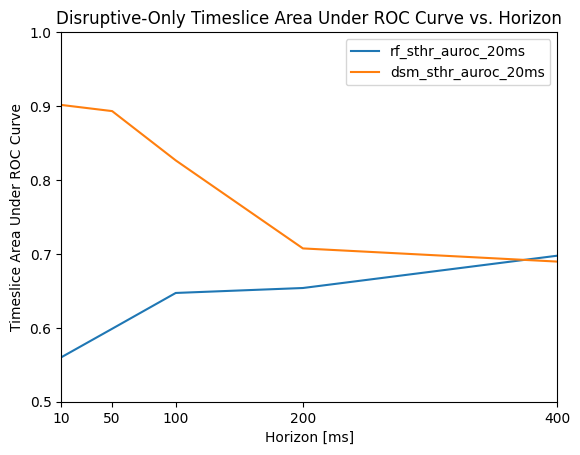

In [2]:
experiment_list = get_experiments(experiment_groups, ['auroc'])
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=False)
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=True)


## Table of Metrics:

In [11]:
required_warning_time = 0.02

result_data = []
for experiment in experiment_list:
    auroc = experiment.evaluate_metric('auroc', required_warning_time=required_warning_time)
    auwtc = experiment.evaluate_metric('auwtc', required_warning_time=required_warning_time)
    maxf1 = experiment.evaluate_metric('maxf1', required_warning_time=required_warning_time)
    tar, far, avg_warn, std_warn = experiment.max_f1_info(required_warning_time=required_warning_time)
    
    result_array = [experiment.name, auroc, auwtc*1000, maxf1, tar, far, avg_warn*1000, std_warn*1000]
    result_data.append(result_array)
    
result_df = pd.DataFrame(result_data, columns=['Experiment Name', 'AUROC', 'AUWTC', 'Max F1', 'TAR', 'FAR', 'Avg. Warn [ms]', 'Std. Warn [ms]'])
print(f"Model Performance when Reqired Warning Time is {required_warning_time*1000} ms")
display(result_df)

Model Performance when Reqired Warning Time is 20.0 ms


,Experiment Name,AUROC,AUWTC,Max F1,TAR,FAR,Avg. Warn [ms],Std. Warn [ms]
0,rf_sthr_auroc_20ms,0.683871,2.481148,0.500000,0.4,0.032258,[69.17160045069615],[8.616685924568879]
1,dsm_sthr_auroc_20ms,0.938710,0.575973,0.714286,1.0,0.129032,[220.73035284270617],[325.5476963619601]


## ROC Curve

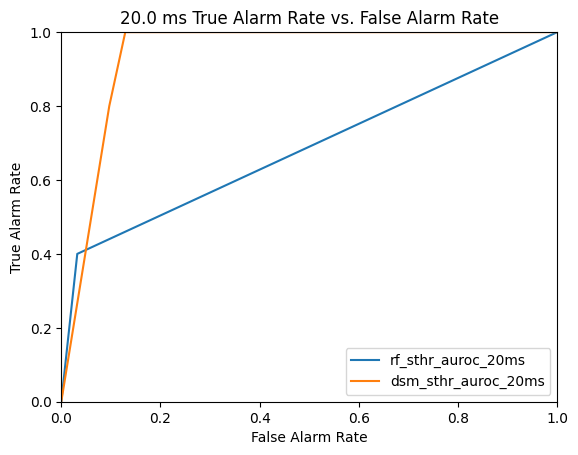

In [4]:
plot_roc_curve(experiment_list, required_warning_time=required_warning_time)

## Area Under Warning Time Curve



c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\plot_experiments.py:157: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min_far, max_far])


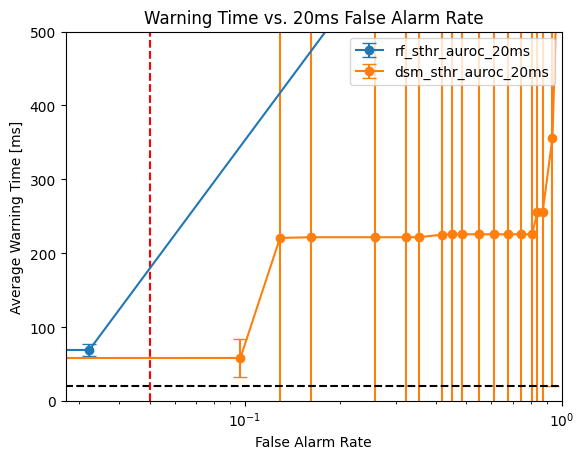

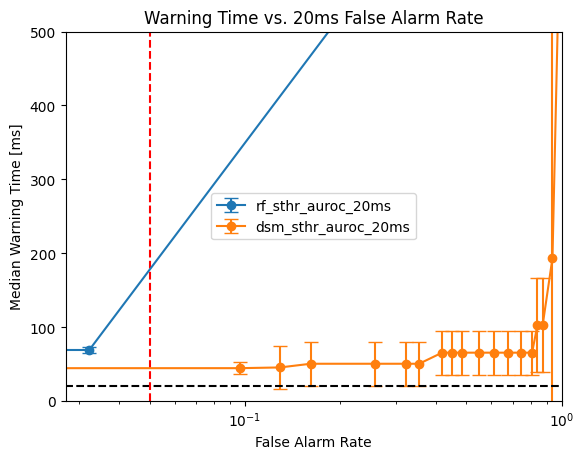

In [5]:
plot_warning_time_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='average')
plot_warning_time_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='median')

## Warning Time vs. Threshold

c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\plot_experiments.py:203: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min_threshold, max_threshold])


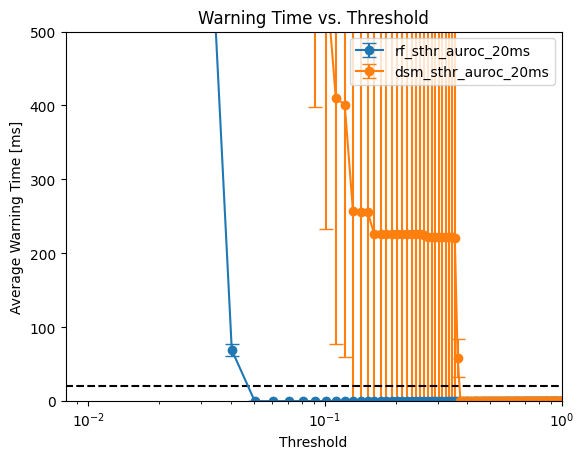

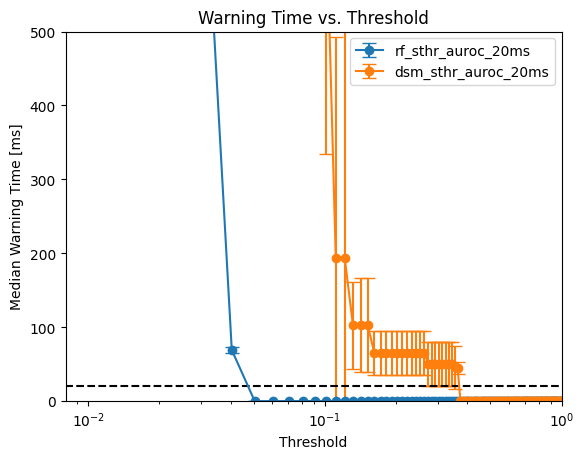

In [6]:
plot_warning_time_vs_threshold(experiment_list, cutoff_far=0.05, method='average')
plot_warning_time_vs_threshold(experiment_list, cutoff_far=0.05, method='median')

## False Positive Rate vs. Threshold

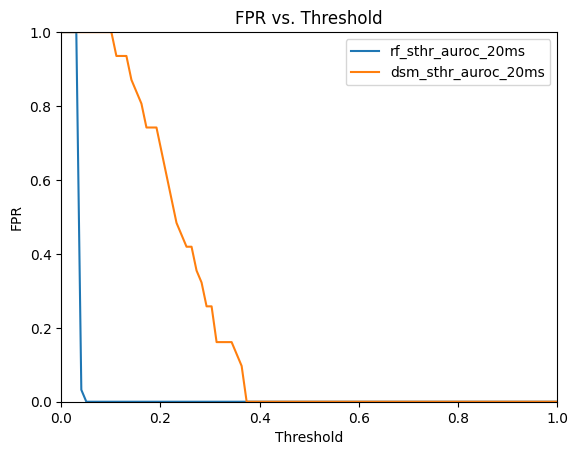

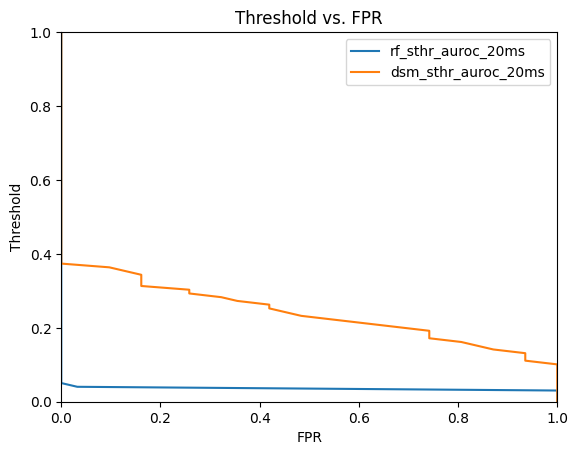

In [7]:
plot_fpr_vs_threshold(experiment_list, cutoff_far=0.05, method='average')
plot_threshold_vs_fpr(experiment_list, cutoff_far=0.05, method='average')

## Model Output plotted over time

Dotted line is the hyperparameter horizon / class time. (How far before the disruption the model should start to 'see' it coming)

Solid line is required warning time.

c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\plot_experiments.py:310: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


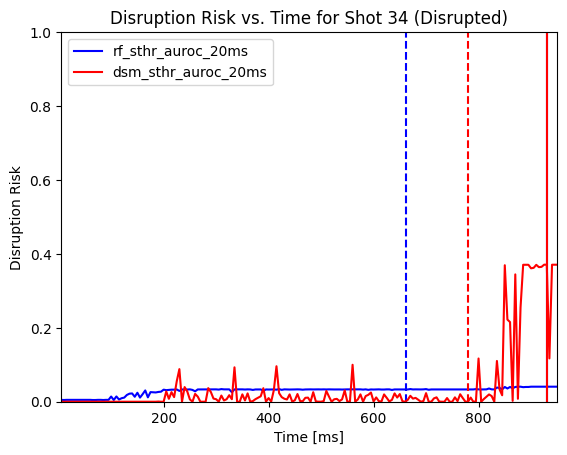

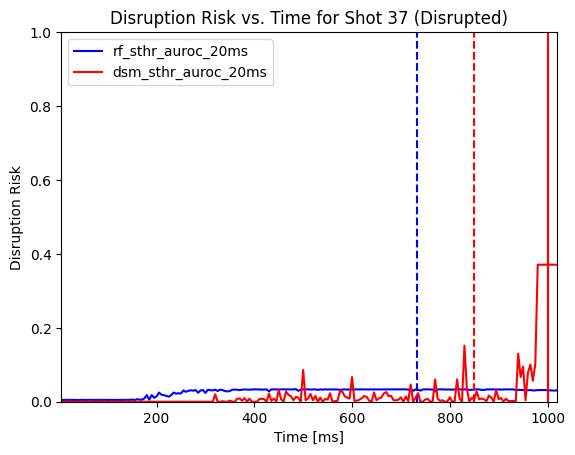

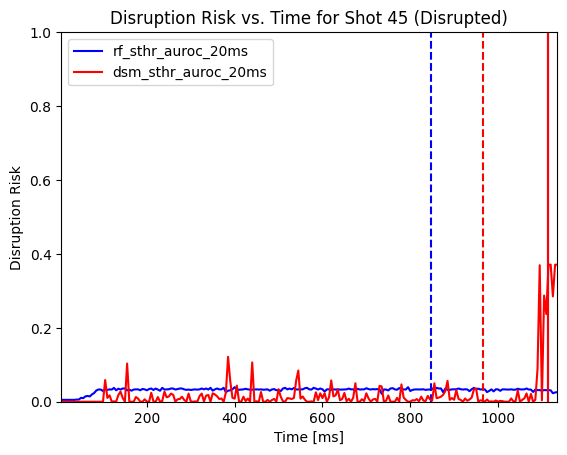

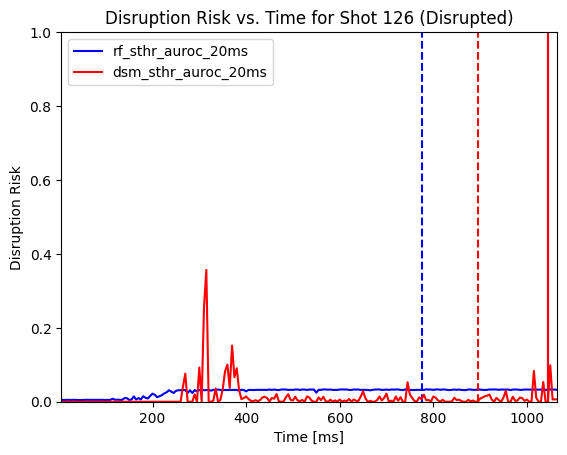

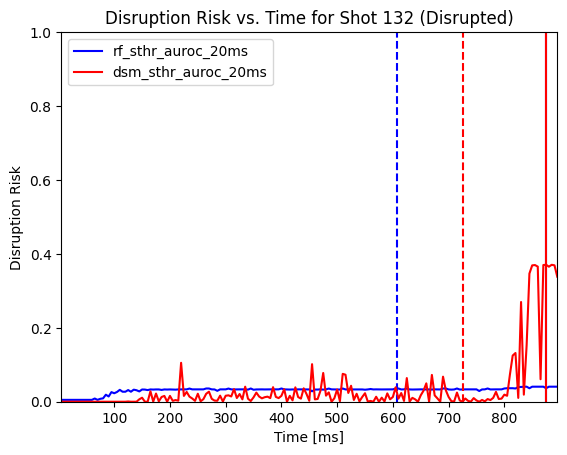

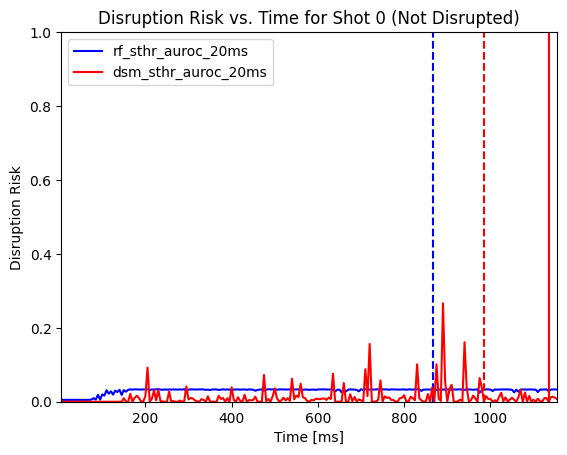

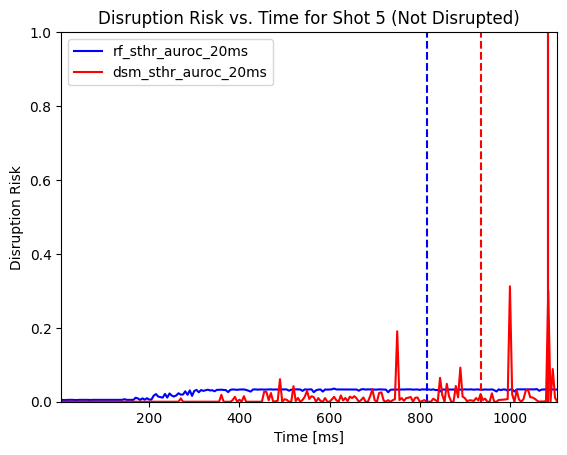

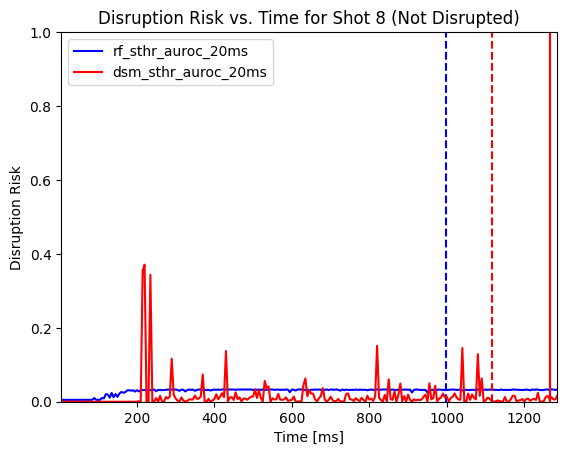

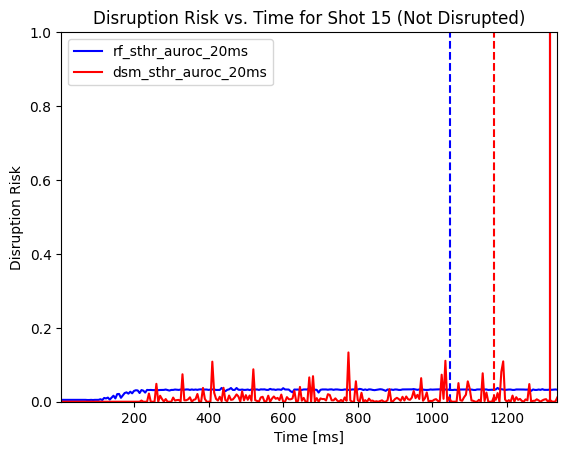

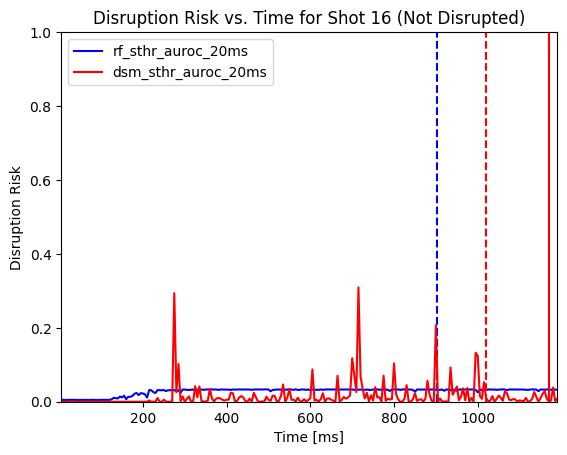

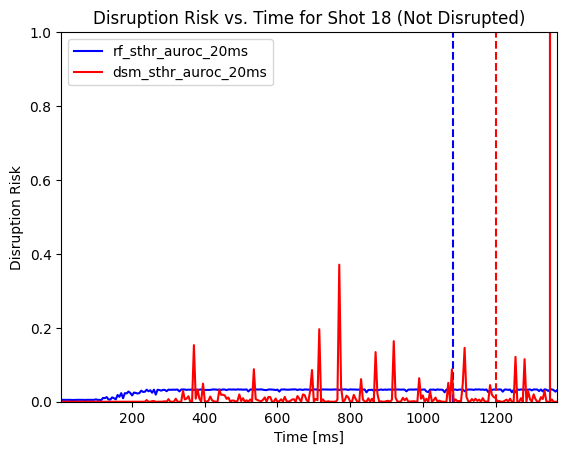

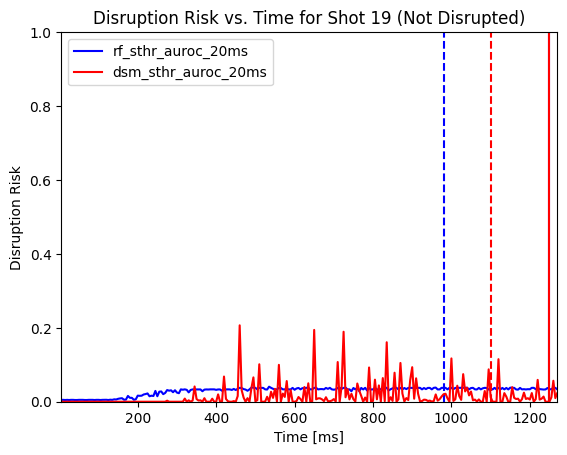

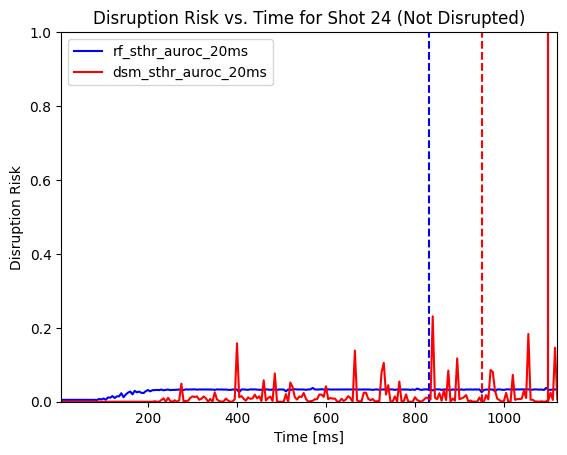

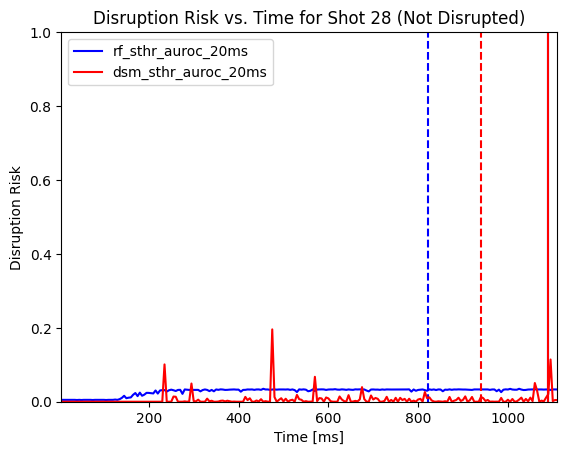

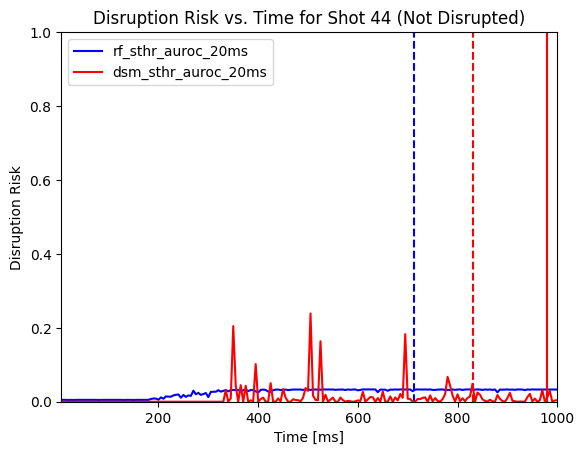

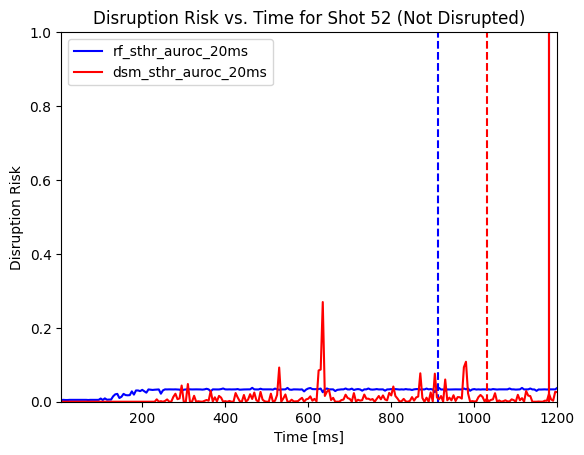

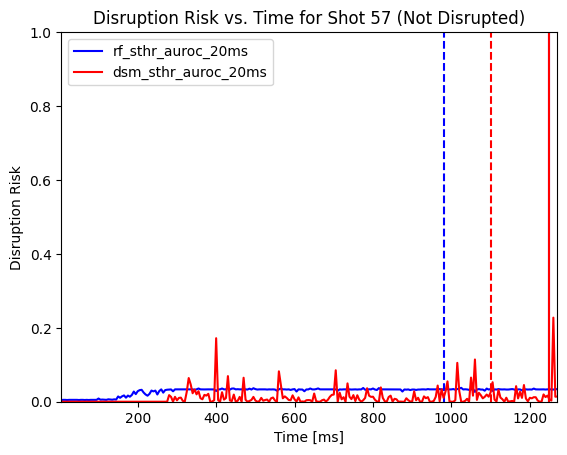

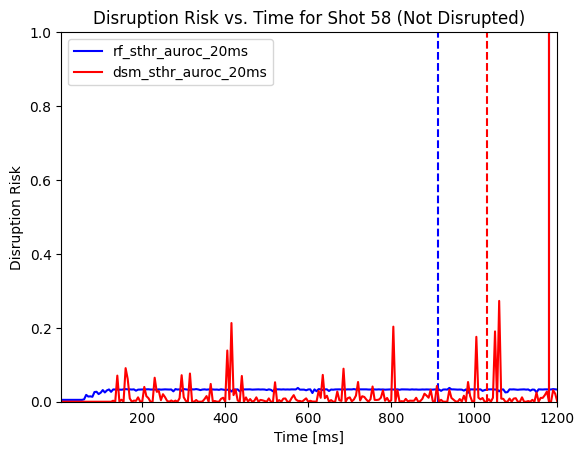

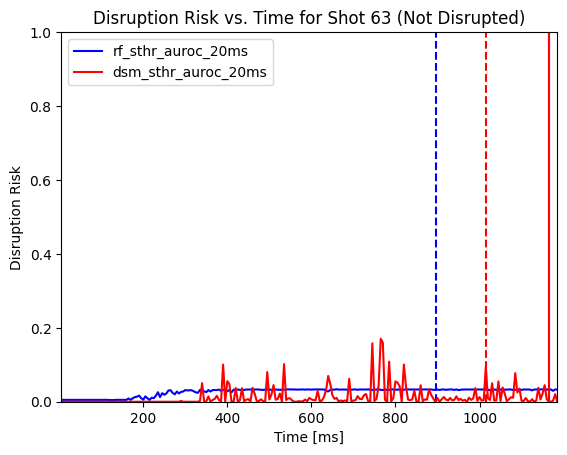

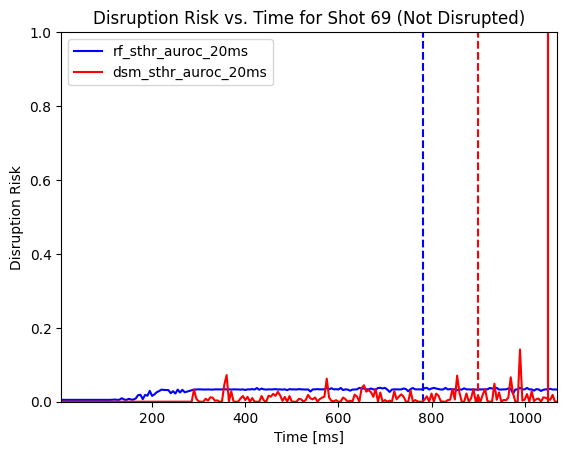

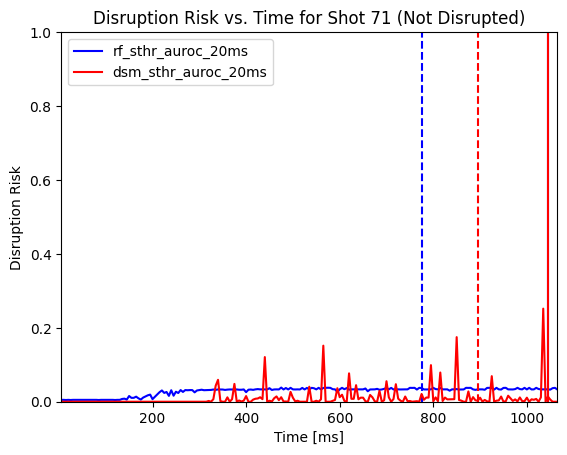

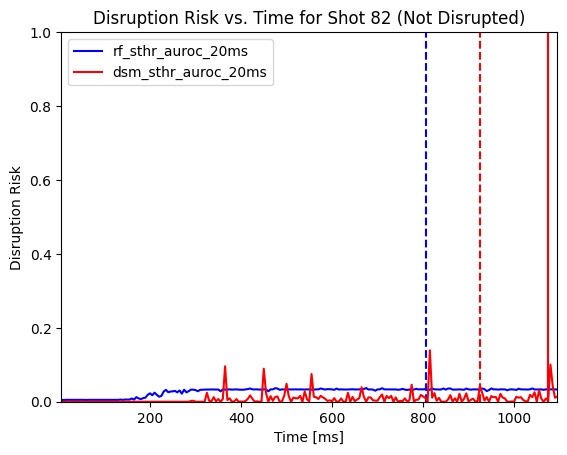

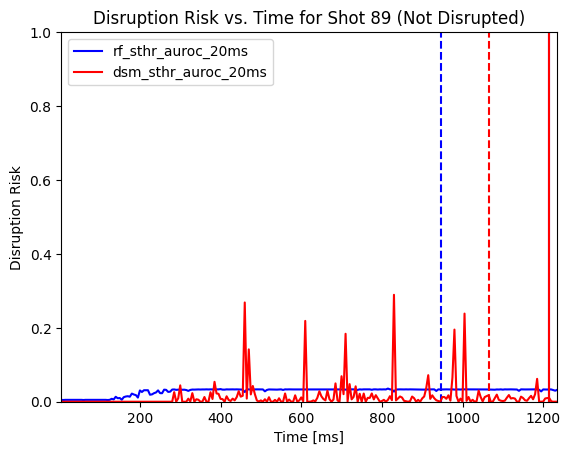

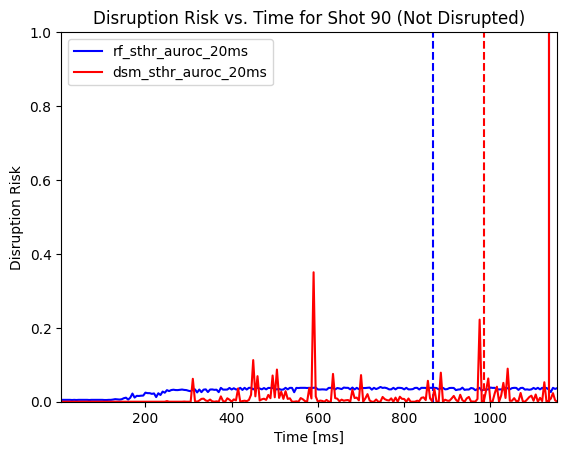

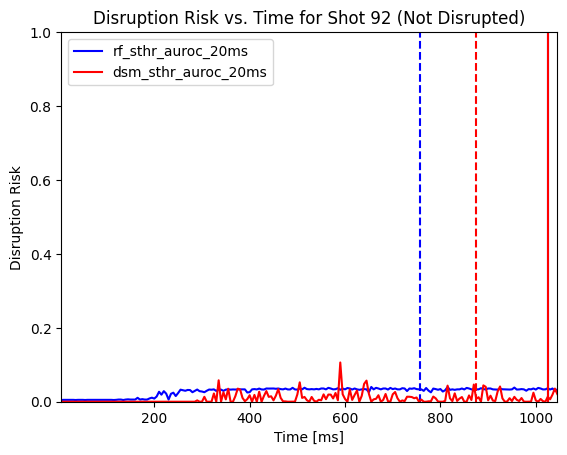

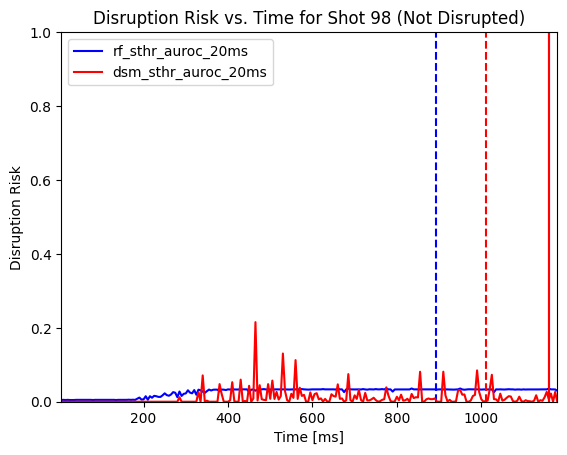

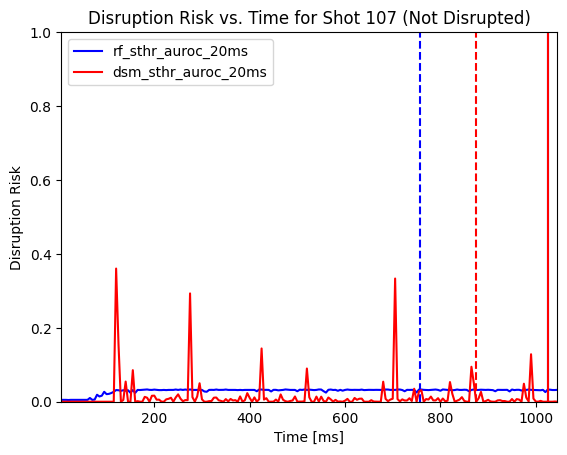

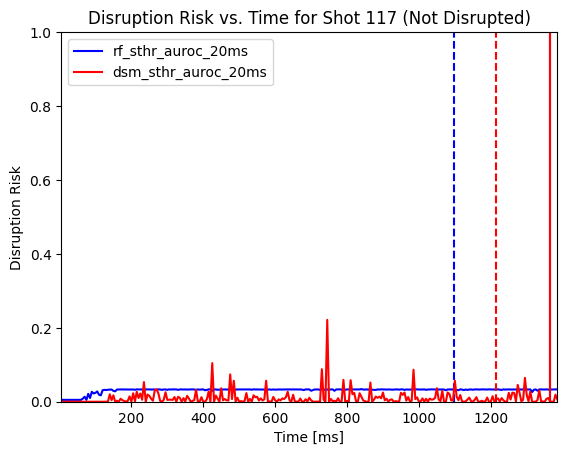

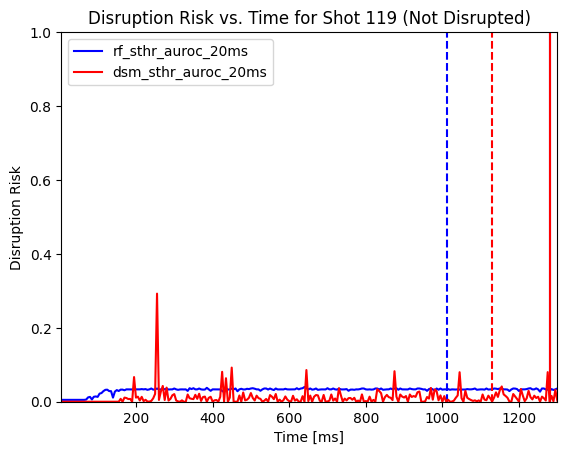

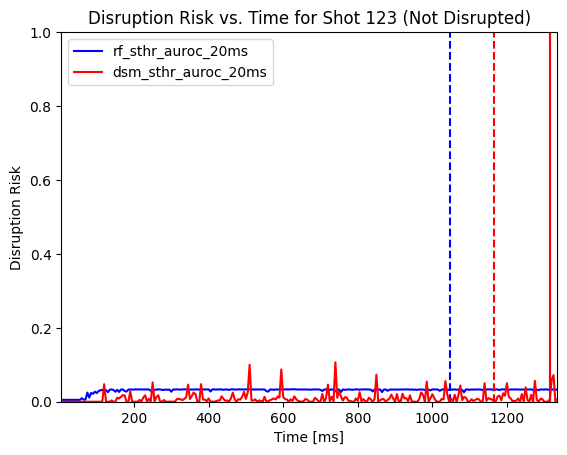

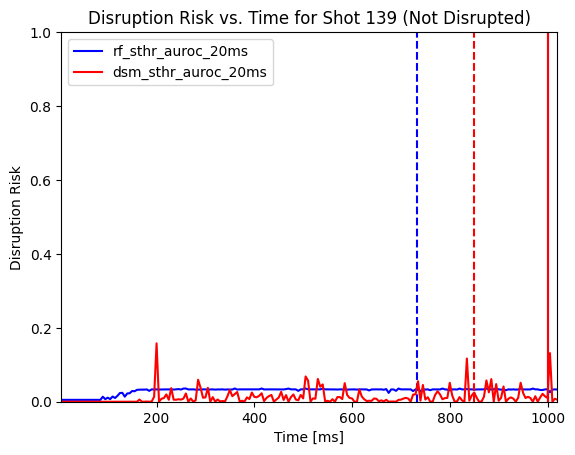

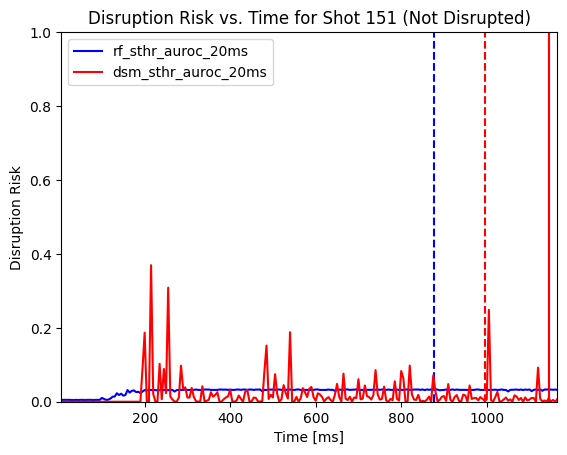

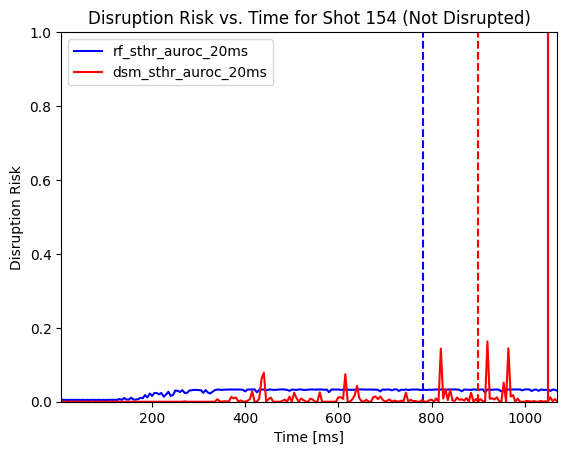

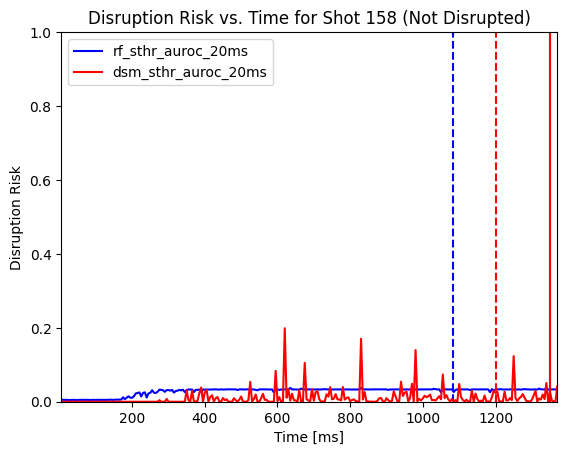

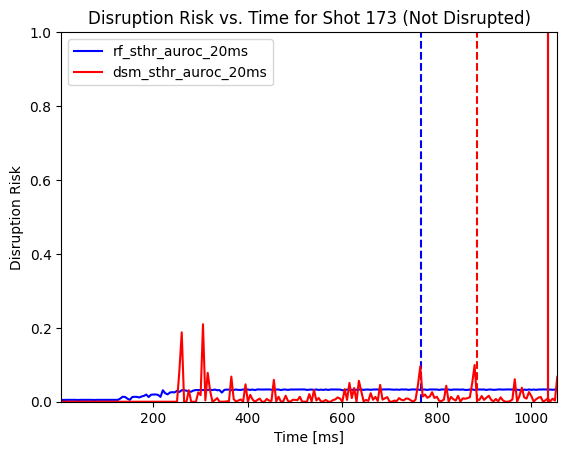

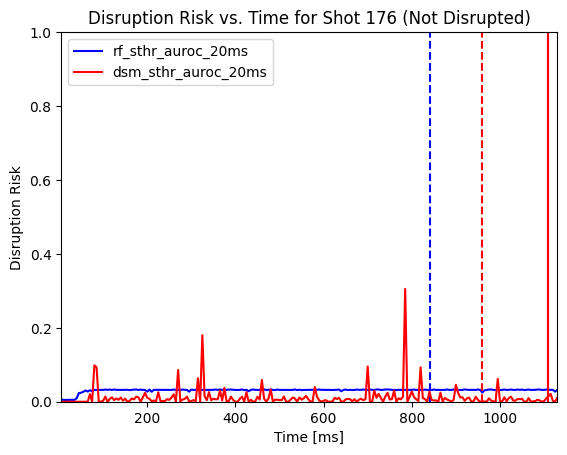

In [8]:
for shot_number in experiment_list[0].get_disruptive_shot_list():
    plot_risk_compare_models(experiment_list, shot_number)
    #plot_ettd_compare_models(experiment_list, shot_number)

for shot_number in experiment_list[0].get_non_disruptive_shot_list():
    plot_risk_compare_models(experiment_list, shot_number)
    #plot_ettd_compare_models(experiment_list, shot_number)


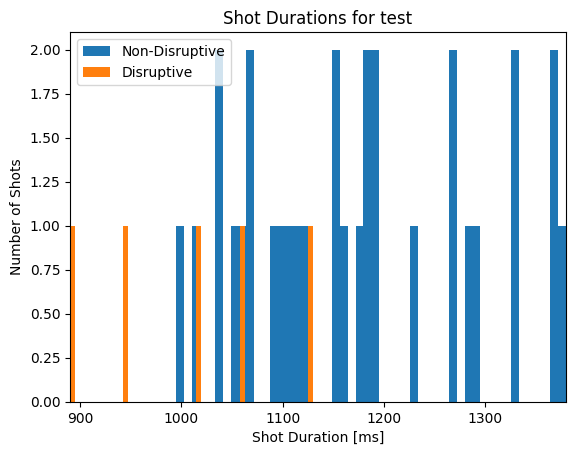

In [9]:
plot_disruptive_vs_non_disruptive_shot_durations(experiment_list[0])